In [1]:
from basicrnn_model import *
import copy
from datetime import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

In [2]:
def create_graph(file_name, title, train_data, valid_data, x_label="# of Epochs", y_label="Loss"):
    fig, graph = plt.subplots(nrows=1, ncols=1, figsize=(7,6), sharex=True)
    fig.suptitle(title, y=1)
    fig.tight_layout()
    fig.subplots_adjust(top=.85, wspace=.3)
    graph.set_ylabel(y_label)
    graph.set_xlabel(x_label)
    if train_data is not None:
        graph.plot(list(range(len(train_data))), train_data, linestyle='-', color='red', marker='o', label="train")
    if valid_data is not None:
        graph.plot(list(range(len(valid_data))), valid_data, linestyle='-', color='blue', marker='o', label="validation")
    graph.legend()
    plt.savefig(file_name, bbox_inches='tight')

In [3]:
def read_music(filepath, splits=True):
    data = []
    with open(filepath, mode='r', encoding='utf-8') as f:
        if not splits:
            data.append('')
            wait_for_start = False
        else:
            wait_for_start = True
        for _, line in enumerate(f):
            if splits:
                if '<start>' in line:
                    data.append('%\n')
                    wait_for_start = False
                    continue
                elif '<end>' in line:
                    data[-1] += ';'
                    wait_for_start = True
                    continue
            if not wait_for_start:
                data[-1] += line
    return data

In [4]:
s = ''
for p in read_music('train.txt'):
    s += p
s = set(s)
one_hot_decode = {}
one_hot_encode = {}
for i, c in enumerate(s):
    one_hot_decode[i] = c
    one_hot_encode[c] = i
one_hot_decode[i+1] = '\0'
one_hot_encode['\0'] = i+1

In [5]:
def encode_char(c):
    z = [0] * len(one_hot_decode)
    z[one_hot_encode[c]] = 1
    return z

In [6]:
def decode_one_hot(one_hot):
    z = one_hot_decode[torch.argmax(one_hot).item()]
    if z == '%':
        z = '<start>'
    elif z == ';':
        z = '<end>'
    return z

In [7]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

hidden_neurons = 100
num_layers = 1

model = RNN(len(one_hot_encode), hidden_neurons, num_layers).to(computing_device)
print(model)

CUDA is supported
RNN(
  (rnn): RNN(96, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=96, bias=True)
)


In [8]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training

In [9]:
epochs = 50
chunk_size = 100
early_stop = 2

train_loss = []
valid_loss = []
best_model_wts = copy.deepcopy(model.state_dict()) 

train_set = read_music("train.txt")
valid_set = read_music("val.txt")
for epoch in range(epochs):
    current_time = datetime.now().strftime("%H:%M:%S")
    print(f"{current_time}: Started epoch {epoch}")
    random.shuffle(train_set)
    for mode in ['train', 'valid']:
        with torch.set_grad_enabled(mode == 'train'):
            if mode == 'train':
                model.train()
                dataset = train_set
            elif mode == 'valid':
                model.eval()
                dataset = valid_set
            piece_loss_sum = 0

            for piece in dataset:
                hidden = model.init_hidden()
                loss_sum = 0
                for chunk_num in range((len(piece)//chunk_size) + (((len(piece)%chunk_size) != 0) and (len(piece) > chunk_size))):
                    if mode == 'train':
                        optimizer.zero_grad()
                    chunk_index = chunk_num * chunk_size
                    X = [encode_char(c) for c in piece[chunk_index:chunk_index + chunk_size]]
                    y = [one_hot_encode[c] for c in piece[(chunk_index + 1):chunk_index + chunk_size + 1]]
                    if len(y) != len(X):
                        y.append(one_hot_encode['\0'])

                    X = torch.tensor([X], dtype=torch.float, device=computing_device)
                    y = torch.tensor(y, dtype=torch.long, device=computing_device)

                    output, hidden = model(X, hidden)
                    loss = criterion(output[0], y)
                    if mode == 'train':
                        loss.backward()
                    loss_sum += loss.item()
                    if mode == 'train':
                        optimizer.step()

                piece_loss_sum += (loss_sum/(chunk_num + 1))
            if mode == 'train':
                train_loss.append(piece_loss_sum/len(train_set))
                print(f"Train loss: {train_loss[-1]}")
            elif mode == 'valid':
                valid_loss.append(piece_loss_sum/len(valid_set))
                print(f"Valid loss: {valid_loss[-1]}")
            
    current_time = datetime.now().strftime("%H:%M:%S")
    print(f"{current_time}: Finished epoch {epoch}")

    if len(valid_loss) > 1 and valid_loss[-1] < min(valid_loss[:-1]):
        best_model_wts = copy.deepcopy(model.state_dict())
    if len(valid_loss) > early_stop:
        if sum([1 for l, l1 in zip(valid_loss[-(early_stop+1):], valid_loss[-early_stop:]) if l1 > l]) == early_stop:
            break

model.load_state_dict(best_model_wts)

12:35:04: Started epoch 0
Train loss: 3.44493471247025
Valid loss: 3.228229470484103
12:35:34: Finished epoch 0
12:35:34: Started epoch 1
Train loss: 2.9172328617624603
Valid loss: 2.8538138606139865
12:36:04: Finished epoch 1
12:36:04: Started epoch 2
Train loss: 2.6060366387244667
Valid loss: 2.6433014409578
12:36:34: Finished epoch 2
12:36:34: Started epoch 3
Train loss: 2.419436650228114
Valid loss: 2.5262638173105065
12:37:02: Finished epoch 3
12:37:02: Started epoch 4
Train loss: 2.292011036658804
Valid loss: 2.442544680391571
12:37:31: Finished epoch 4
12:37:31: Started epoch 5
Train loss: 2.196131650455415
Valid loss: 2.365757074567078
12:38:00: Finished epoch 5
12:38:00: Started epoch 6
Train loss: 2.1203708703366977
Valid loss: 2.305875701798707
12:38:29: Finished epoch 6
12:38:29: Started epoch 7
Train loss: 2.059663215408816
Valid loss: 2.2617527298342646
12:38:57: Finished epoch 7
12:38:57: Started epoch 8
Train loss: 2.007266375039054
Valid loss: 2.2279292583531065
12:39:

<All keys matched successfully>

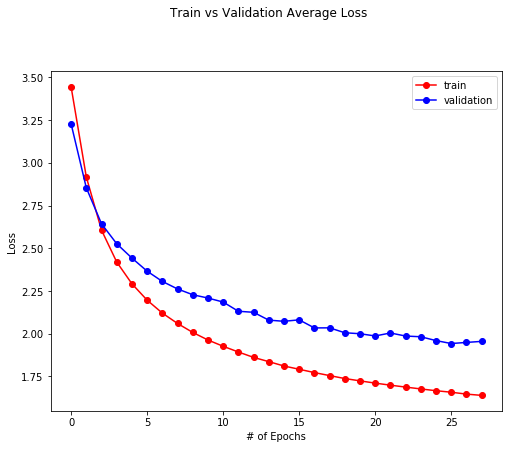

In [10]:
create_graph(f"{hidden_neurons}_{str(learning_rate).replace('.', '')}_{chunk_size}_{num_layers}_train_valid_graph",
            "Train vs Validation Average Loss",
            train_loss,
            valid_loss)

Testing

In [ ]:
total_samples = 0
truth_results = {"TP": 0,
                 "FP": 0,
                 "FN": 0}

with torch.set_grad_enabled(mode == 'train'):
    model.eval()
    test_set = read_music('test.txt')
    piece_loss_sum = 0
    for piece in dataset:
        hidden = model.init_hidden()
        loss_sum = 0
        for chunk_num in range((len(piece)//chunk_size) + (((len(piece)%chunk_size) != 0) and (len(piece) > chunk_size))):
            chunk_index = chunk_num * chunk_size
            X = [encode_char(c) for c in piece[chunk_index:chunk_index + chunk_size]]
            y = [one_hot_encode[c] for c in piece[(chunk_index + 1):chunk_index + chunk_size + 1]]
            if len(y) != len(X):
                y.append(one_hot_encode['\0'])

            X = torch.tensor([X], dtype=torch.float, device=computing_device)
            actual = torch.tensor(y, dtype=torch.long, device=computing_device)

            output, hidden = model(X, hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())
            
            s = nn.Softmax(dim=1)
            predicted = torch.argmax(s(output[0]), dim=1)
            for pred, act in zip(predicted, actual):
                total_samples += 1
                if pred == act:
                    truth_results["TP"] += 1
                else:
                    truth_results["FP"] += 1
                    truth_results["FN"] += 1

accuracy = (truth_results["TP"] / total_samples) * 100
precision = truth_results["TP"] / (truth_results["FP"] + truth_results["TP"]) if truth_results["FP"] + truth_results["TP"] > 0 else 0
recall = truth_results["TP"] / (truth_results["TP"] + truth_results["FN"])
bcr = (precision + recall) / 2

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, BCR: {bcr}")

In [15]:
def softmax_t(input, t=1):
    """
    Args:
        input - hidden layer tensor to take softmax of
        t     - temperature
    """
    return func.softmax((input / t), dim=2, dtype=float)

def generate(t=1, n=0, p='<start>'):
    """
    Args:
        t - temperature; if t=0, uses maximum argument instead of temperature
        n - label of sample; used to prevent overwriting old samples. To generate multiple samples,
               call generate in a for loop over n
        p - priming sequence, which should begin with '<start>'
    """
    with torch.no_grad():
        model.eval()
        if t == 0:
            file = "gen_m" + "-" + str(n) + ".txt"
        else:
            file = "gen_t" + str(t) + "-" + str(n) + ".txt"

        with open(file, "w+") as f:
            f.write(p)
        with open(file, "a+") as f:
            #priming
            hidden = model.init_hidden()
            p = '%' + p[7:]
            for c in p:
                cur_char = torch.tensor([[encode_char(c)]], dtype=torch.float, device=computing_device)
                _, hidden = model(cur_char, hidden)
            #generating
            end = decode_one_hot(torch.tensor([[encode_char(';')]], dtype=torch.float, device=computing_device))
            while True:
                output, hidden = model(cur_char, hidden)
                if t == 0:
                    cur_char = decode_one_hot(output)
                else:
                    sm = softmax_t(output, t).tolist()[0][0]
                    cur_char = random.choices(list(one_hot_encode.keys()), weights=sm)[0]
                    if cur_char == ';': cur_char = end
                f.write(cur_char)
                if cur_char == end:
                    break
                cur_char = torch.tensor([[encode_char(cur_char)]], dtype=torch.float, device=computing_device)
                
                    
generate(t=1, n=0, p='<start>')

In [ ]:
def heatmap(file, node=0, fsize=(20,20), tsize=16, save=False):
    """
    Args:
        file - sample file to forward propagate on
        node - target hidden node to get heatmap of; to print heatmaps for all hidden nodes,
               call heatmap in a for loop over node
        fsize - figure size
        tsize - text size
    """
    sample = read_music(file)[0]
    #sample = sample[1:(len(sample)-1)]
    s = torch.tensor([[encode_char('%')]], dtype=torch.float, device=computing_device)
    _, hidden = model(s, model.init_hidden())
    hnode = []
    for c in sample:
        c = torch.tensor([[encode_char(c)]], dtype=torch.float, device=computing_device)
        _, hidden = model(c, hidden)
        hnode.append(hidden[0][0,0,node].item())
    #graphing stuff
    n = int(np.sqrt(len(hnode)))
    hnode = split(hnode, n, np.nan)
    hnode = np.array(hnode)
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(hnode, "coolwarm", vmin=-1, vmax=1)
    sample = ['<s>' if c == '%' else '<e>' if c == ";" else '\\n' if c == '\n' else 'sp' if c == ' ' else c for c in sample]
    sample = split(sample, n, '')
    for i in range(len(hnode)):
        for j in range(len(hnode[0])):
            text = ax.text(j, i, sample[i][j],
                ha="center", va="center", color="k", size=tsize)
            text.set_path_effects([PathEffects.withStroke(linewidth=(tsize//4), foreground='w')])
    cbar = ax.figure.colorbar(im, ax=ax)
    gfile = file[:-4] + "_heatmap_hnode" + str(node)
    if save: plt.savefig(gfile, bbox_inches='tight')

def split(l, n, b):
    """
    Args:
        l - list to split into equal parts
        n - size of the sublists that l is split into
        b - base value to pad empty entries
    """
    l = [l[i * n:(i + 1) * n] for i in range((len(l) + n - 1) // n )]
    l[-1] = [l[-1][i] if i < len(l[-1]) else b for i in range(len(l[0]))]
    return l

heatmap("gen_t1-0.txt", node=11, fsize=(20,20), tsize=16, save=True)
heatmap("gen_t1-0.txt", node=20, fsize=(20,20), tsize=16, save=True)
